# Deep Learning Time Series Forecasting with DeepAR

## Overview
This notebook implements a streamlined time series forecasting pipeline using the **DeepAR (Deep AutoRegressive)** model from GluonTS.

## Workflow
1. **Data Loading**: Ingesting prepared Rossmann Store Sales data.
2. **Feature Engineering**: Cleaning series and encoding categorical variables.
3. **Data Preparation**: formatting data into GluonTS `ListDataset` format.
4. **Model Training**: Training a DeepAR Estimator on the full dataset.
5. **Evaluation**: Calculating key performance metrics (**MAPE, MAE, sMAPE, MASE, RMSE**).
6. **Visualization**: Plotting forecasts against actuals and analyzing error distributions.

## 1. Environment Setup

Importing necessary libraries, setting random seeds for reproducibility, and configuring the environment.

In [ ]:
#%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 800.9 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 kB 2.4 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Core dependencies
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from typing import List, Tuple, Dict, Optional
from tqdm.auto import tqdm

# Deep learning and time series libraries
import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

# Scikit-learn for additional metric verification
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.6f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("===== Version Information =====")
print(f"Python version          : {os.sys.version}")
print(f"NumPy                   : {np.__version__}")
print(f"Pandas                  : {pd.__version__}")
print(f"Matplotlib              : {matplotlib.__version__}")
print(f"Seaborn                 : {sns.__version__}")
print(f"Torch                   : {torch.__version__}")
print(f"GluonTS                 : {gluonts.__version__}")
print(f"scikit-learn            : {sklearn.__version__}")
print(f"TQDM                    : {tqdm.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

===== Version Information =====
Python version          : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy                   : 2.1.3
Pandas                  : 2.3.3
Matplotlib              : 3.10.7
Seaborn                 : 0.13.2
Torch                   : 2.9.1+cu128
GluonTS                 : 0.16.2
scikit-learn            : 1.7.2
TQDM                    : 4.67.1
PyTorch version: 2.9.1+cu128
CUDA available: True


## 2. Configuration

We define a central configuration class to manage hyperparameters, file paths, and forecast settings (prediction length, frequency, etc.).

In [ ]:
class Config:
    """Central configuration for the DeepAR forecasting pipeline."""
    
    # Data paths
    DATA_PATH = "./data"
    TRAIN_FILE = "train.csv"
    OUTPUT_DIR = "./outputs"
    PLOTS_DIR = "./outputs/plots"
    
    # Time series parameters
    PREDICTION_LENGTH = 48
    FREQ = "D"
    SEASONALITY_PERIOD = 7
    
    # Validation settings
    VALIDATION_MODE = True
    
    # DeepAR hyperparameters
    DEEPAR_CONFIG = {
        'context_length': 2 * PREDICTION_LENGTH,
        'num_layers': 3,
        'hidden_size': 64,
        'dropout_rate': 0.1,
        'lr': 1e-3,
        'epochs': 20,
        'batch_size': 32,
        'num_batches_per_epoch': 400,
    }
    
    # Evaluation settings
    NUM_SAMPLES = 100
    QUANTILES = [0.1, 0.5, 0.9]
    
    # Visualization settings
    NUM_PLOTS = 3
    PLOT_LENGTH = 200

# Create output directories
Path(Config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(Config.PLOTS_DIR).mkdir(parents=True, exist_ok=True)
print(f"Config loaded. Forecasting horizon: {Config.PREDICTION_LENGTH} days.")

Config loaded. Forecasting horizon: 48 days.


## 3. Data Loading

Loading the CSV data and converting the date column to the correct datetime format.

In [11]:
def load_and_merge_data(data_path: str, train_file: str, store_file: str) -> pd.DataFrame:
    path = Path(data_path)
    
    print("Loading data...")
    train_df = pd.read_csv(path / train_file)
    store_df = pd.read_csv(path / store_file)
    
    # Convert Date
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    
    # Merge Store Metadata (Static Features) into the main dataframe
    print("Merging store metadata...")
    # Merging ensures every row has the store's specific attributes (Type, Assortment, etc.)
    df = pd.merge(train_df, store_df, on='Store', how='left')
    
    # Fill NaNs in CompetitionDistance (common in Rossmann) with median or 0
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    
    print(f"Merged Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    return df

# Usage
# Assuming 'store.csv' is in the same directory
df = load_and_merge_data(Config.DATA_PATH, Config.TRAIN_FILE, "store.csv")

Loading data...
Merging store metadata...
Merged Data loaded: 1,017,209 rows, 18 columns


## 4. Feature Engineering

### 4.1 Cleaning and Encoding
1. **Clean Time Series**: We remove store data that is incomplete to ensure all series have the same length for batch processing.
2. **Encode Categoricals**: We convert categorical features (like Store ID, State, etc.) into numerical codes required by the DeepAR embedding layers.

In [12]:
# 1. Clean Data (Remove incomplete series)
def clean_time_series(df: pd.DataFrame, id_col: str = 'Store') -> pd.DataFrame:
    target_length = df[id_col].value_counts().max()
    print(f"Target series length: {target_length}")
    
    df_clean = df.groupby(id_col).filter(lambda x: len(x) == target_length)
    df_clean = df_clean.sort_values(['Date', id_col]).reset_index(drop=True)
    df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('^Unnamed', case=False)]
    
    print(f"Cleaned dataset: {df_clean['Store'].nunique()} stores remaining.")
    return df_clean

df = clean_time_series(df)

# 2. Encode Categoricals
def encode_all_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, int], List[int]]:
    # We now have more static categorical features from store.csv
    static_cols = ['Store', 'StoreType', 'Assortment'] 
    
    df_encoded = df.copy()
    cardinalities = {}
    cardinality_list = []
    
    print("Encoding static features...")
    for var in static_cols:
        # Convert to category and get codes
        df_encoded[var] = df_encoded[var].astype('category')
        df_encoded[f'{var}_cat'] = df_encoded[var].cat.codes
        
        # Calculate cardinality (how many unique values)
        unique_count = df_encoded[var].nunique()
        cardinalities[var] = unique_count
        cardinality_list.append(unique_count)
        
    return df_encoded, cardinalities, cardinality_list

df, cardinalities, static_cardinalities = encode_all_features(df)

print(f"Static features encoded: ['Store', 'StoreType', 'Assortment']")
print(f"Cardinalities: {static_cardinalities}") 
# Output might look like [1115, 4, 3] (1115 stores, 4 types, 3 assortments)

Target series length: 942
Cleaned dataset: 934 stores remaining.
Encoding static features...
Static features encoded: ['Store', 'StoreType', 'Assortment']
Cardinalities: [934, 4, 3]


## 5. Data Preparation

### 5.1 Creating GluonTS Datasets
DeepAR requires data in a specific dictionary format (or `ListDataset`). We prepare:
1. **Train Dataset**: Excluding the last `prediction_length` days.
2. **Test Dataset**: Containing the full data (the model will mask the end automatically during testing).
3. **Static Features**: Adding Store ID as a static categorical feature.

In [13]:
# 1. Prepare Target Arrays
def prepare_target_values(df: pd.DataFrame, prediction_length: int) -> Tuple[np.ndarray, np.ndarray]:
    num_series = df['Store'].nunique()
    series_length = df['Store'].value_counts().iloc[0]
    
    # Shape: (num_series, time_steps)
    target_values = df['Sales'].values.reshape(series_length, num_series).T
    
    # Split for validation
    train_targets = target_values[:, :-prediction_length]
    test_targets = target_values  # Test uses full length
    
    return train_targets, test_targets

train_target_values, test_target_values = prepare_target_values(df, Config.PREDICTION_LENGTH)

# 2. Create GluonTS ListDatasets
print("Creating GluonTS ListDatasets...")

# Prepare static features array: Shape (num_series, num_static_features)
# We group by store and take the first value (since they are static, they don't change)
static_features_df = df.groupby('Store')[['Store_cat', 'StoreType_cat', 'Assortment_cat']].first()
static_feat_array = static_features_df.values # Shape: (1115, 3)

print("Creating enhanced GluonTS Datasets...")

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: df['Date'].iloc[0],
            # NOW PASSING ALL 3 STATIC FEATURES
            FieldName.FEAT_STATIC_CAT: static_feat_array[i] 
        }
        for i, target in enumerate(train_target_values)
    ],
    freq=Config.FREQ
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: df['Date'].iloc[0],
            # NOW PASSING ALL 3 STATIC FEATURES
            FieldName.FEAT_STATIC_CAT: static_feat_array[i]
        }
        for i, target in enumerate(test_target_values)
    ],
    freq=Config.FREQ
)

print(f"Train dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Creating GluonTS ListDatasets...
Creating enhanced GluonTS Datasets...
Train dataset size: 934
Test dataset size: 934


## 6. Model Training (DeepAR)

We initialize and train the `DeepAREstimator`. 
* **NegativeBinomialOutput**: Used because Sales data is count-based (non-negative).
* **Context Length**: How far back the model looks to make a prediction.

In [15]:
print("\n" + "="*80)
print("TRAINING ENHANCED DEEPAR MODEL")
print("="*80)

# Initialize DeepAR Estimator
estimator = DeepAREstimator(
    freq=Config.FREQ,
    prediction_length=Config.PREDICTION_LENGTH,
    context_length=Config.DEEPAR_CONFIG['context_length'],
    num_layers=Config.DEEPAR_CONFIG['num_layers'],
    hidden_size=Config.DEEPAR_CONFIG['hidden_size'],
    dropout_rate=Config.DEEPAR_CONFIG['dropout_rate'],
    lr=Config.DEEPAR_CONFIG['lr'],
    batch_size=Config.DEEPAR_CONFIG['batch_size'],
    num_batches_per_epoch=Config.DEEPAR_CONFIG['num_batches_per_epoch'],
    trainer_kwargs={"max_epochs": Config.DEEPAR_CONFIG['epochs'], "accelerator": "auto"},
    distr_output=NegativeBinomialOutput(),
    
    # CRITICAL UPDATE: Pass list of cardinalities for [Store, StoreType, Assortment]
    cardinality=static_cardinalities 
)

print("Starting training...")
deepar_predictor = estimator.train(train_ds, num_workers=0)
print("DeepAR training completed!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



TRAINING ENHANCED DEEPAR MODEL
Starting training...


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 93.1 K | train | [[1, 1], [1, 1], [1, 1188, 4], [1, 1188], [1, 1188], [1, 48, 4]] | [1, 100, 48]
--------------------------------------------------------------------------------------------------------------------------------
93.1 K    Trainable params
0         Non-trainable params
93.1 K    Total p

Epoch 0: |          | 400/? [00:18<00:00, 21.83it/s, v_num=0, train_loss=46.80]

Epoch 0, global step 400: 'train_loss' reached 46.83580 (best 46.83580), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=0-step=400.ckpt' as top 1


Epoch 1: |          | 400/? [00:15<00:00, 25.62it/s, v_num=0, train_loss=21.00]

Epoch 1, global step 800: 'train_loss' reached 21.03396 (best 21.03396), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=1-step=800.ckpt' as top 1


Epoch 2: |          | 400/? [00:16<00:00, 24.86it/s, v_num=0, train_loss=26.00]

Epoch 2, global step 1200: 'train_loss' was not in top 1


Epoch 3: |          | 400/? [00:17<00:00, 22.41it/s, v_num=0, train_loss=17.70]

Epoch 3, global step 1600: 'train_loss' reached 17.69407 (best 17.69407), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=3-step=1600.ckpt' as top 1


Epoch 4: |          | 400/? [00:17<00:00, 22.58it/s, v_num=0, train_loss=12.60]

Epoch 4, global step 2000: 'train_loss' reached 12.60587 (best 12.60587), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=4-step=2000.ckpt' as top 1


Epoch 5: |          | 400/? [00:18<00:00, 21.92it/s, v_num=0, train_loss=8.640]

Epoch 5, global step 2400: 'train_loss' reached 8.64021 (best 8.64021), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=5-step=2400.ckpt' as top 1


Epoch 6: |          | 400/? [00:18<00:00, 21.83it/s, v_num=0, train_loss=6.710]

Epoch 6, global step 2800: 'train_loss' reached 6.70643 (best 6.70643), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=6-step=2800.ckpt' as top 1


Epoch 7: |          | 400/? [00:15<00:00, 25.10it/s, v_num=0, train_loss=6.620]

Epoch 7, global step 3200: 'train_loss' reached 6.62391 (best 6.62391), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=7-step=3200.ckpt' as top 1


Epoch 8: |          | 400/? [00:15<00:00, 25.07it/s, v_num=0, train_loss=6.590]

Epoch 8, global step 3600: 'train_loss' reached 6.59446 (best 6.59446), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=8-step=3600.ckpt' as top 1


Epoch 9: |          | 400/? [00:18<00:00, 21.28it/s, v_num=0, train_loss=6.550]

Epoch 9, global step 4000: 'train_loss' reached 6.54838 (best 6.54838), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=9-step=4000.ckpt' as top 1


Epoch 10: |          | 400/? [00:16<00:00, 23.84it/s, v_num=0, train_loss=6.530]

Epoch 10, global step 4400: 'train_loss' reached 6.52550 (best 6.52550), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=10-step=4400.ckpt' as top 1


Epoch 11: |          | 400/? [00:19<00:00, 20.32it/s, v_num=0, train_loss=6.670]

Epoch 11, global step 4800: 'train_loss' was not in top 1


Epoch 12: |          | 400/? [00:17<00:00, 23.19it/s, v_num=0, train_loss=6.510]

Epoch 12, global step 5200: 'train_loss' reached 6.51481 (best 6.51481), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=12-step=5200.ckpt' as top 1


Epoch 13: |          | 400/? [00:19<00:00, 20.29it/s, v_num=0, train_loss=6.470]

Epoch 13, global step 5600: 'train_loss' reached 6.47417 (best 6.47417), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=13-step=5600.ckpt' as top 1


Epoch 14: |          | 400/? [00:17<00:00, 22.48it/s, v_num=0, train_loss=6.460]

Epoch 14, global step 6000: 'train_loss' reached 6.45937 (best 6.45937), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=14-step=6000.ckpt' as top 1


Epoch 15: |          | 400/? [00:20<00:00, 19.80it/s, v_num=0, train_loss=6.440]

Epoch 15, global step 6400: 'train_loss' reached 6.44006 (best 6.44006), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=15-step=6400.ckpt' as top 1


Epoch 16: |          | 400/? [00:16<00:00, 23.61it/s, v_num=0, train_loss=6.420]

Epoch 16, global step 6800: 'train_loss' reached 6.41915 (best 6.41915), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=16-step=6800.ckpt' as top 1


Epoch 17: |          | 400/? [00:14<00:00, 27.46it/s, v_num=0, train_loss=6.430]

Epoch 17, global step 7200: 'train_loss' was not in top 1


Epoch 18: |          | 400/? [00:17<00:00, 22.69it/s, v_num=0, train_loss=6.420]

Epoch 18, global step 7600: 'train_loss' was not in top 1


Epoch 19: |          | 400/? [00:19<00:00, 20.93it/s, v_num=0, train_loss=6.410]

Epoch 19, global step 8000: 'train_loss' reached 6.41045 (best 6.41045), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_0/checkpoints/epoch=19-step=8000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 400/? [00:19<00:00, 20.88it/s, v_num=0, train_loss=6.410]
DeepAR training completed!


## 7. Evaluation

We generate forecasts for the test set and calculate the following key metrics:
* **MAE** (Mean Absolute Error): Average magnitude of errors.
* **MAPE** (Mean Absolute Percentage Error): Error relative to the true value.
* **sMAPE** (Symmetric MAPE): A more stable percentage error, bounded between 0% and 200%.
* **MASE** (Mean Absolute Scaled Error): Measures performance relative to a naive baseline (useful for seasonality).
* **RMSE** (Root Mean Squared Error): Penalizes large errors more strongly and highlights volatility or outliers in predictions.

In [31]:
print("\n" + "="*80)
print("EVALUATING MODEL PERFORMANCE")
print("="*80)

# 1. Generate forecasts
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=deepar_predictor,
    num_samples=Config.NUM_SAMPLES
)

print("Processing forecasts...")
# We use list() to materialize the generators so we can iterate them multiple times if needed
deepar_forecasts = list(tqdm(forecast_it, total=len(test_ds)))
deepar_tss = list(tqdm(ts_it, total=len(test_ds)))

# 2. Calculate Metrics using GluonTS Evaluator
evaluator = Evaluator(quantiles=Config.QUANTILES, seasonality=Config.SEASONALITY_PERIOD)
agg_metrics, item_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

# 3. Extract and Display Specific Metrics
print("\n" + "-"*40)
print("KEY PERFORMANCE METRICS")
print("-" * 40)

# MANUALLY CALCULATE MAE
# MAE = Total Absolute Error / Total Number of Predictions
total_predictions = len(test_ds) * Config.PREDICTION_LENGTH
calculated_mae = agg_metrics['abs_error'] / total_predictions

final_metrics = {
    "MAE": calculated_mae,           # Manually calculated MAE
    "MAPE": agg_metrics['MAPE'],
    "sMAPE": agg_metrics['sMAPE'],
    "MASE": agg_metrics['MASE'],
    "RMSE": agg_metrics['RMSE']
}

metrics_df = pd.DataFrame([final_metrics])
display(metrics_df.style.format("{:.4f}").background_gradient(axis=1))

# Save metrics to file
metrics_df.to_csv(Path(Config.OUTPUT_DIR) / 'deepar_key_metrics.csv', index=False)
print(f"\nDetailed per-item metrics saved to {Config.OUTPUT_DIR}")


EVALUATING MODEL PERFORMANCE
Processing forecasts...


100%|██████████| 934/934 [00:00<00:00, 12303.45it/s]
Running evaluation: 934it [00:00, 20239.31it/s]



----------------------------------------
KEY PERFORMANCE METRICS
----------------------------------------


,MAE,MAPE,sMAPE,MASE,RMSE
0,1079.0073,0.1775,0.2115,0.5316,1730.5012



Detailed per-item metrics saved to ./outputs


## 8. Visualization

### 8.1 Forecast Plots
Visualizing the model's predictions against ground truth for random samples, including confidence intervals.


Plotting 3 sample forecasts...


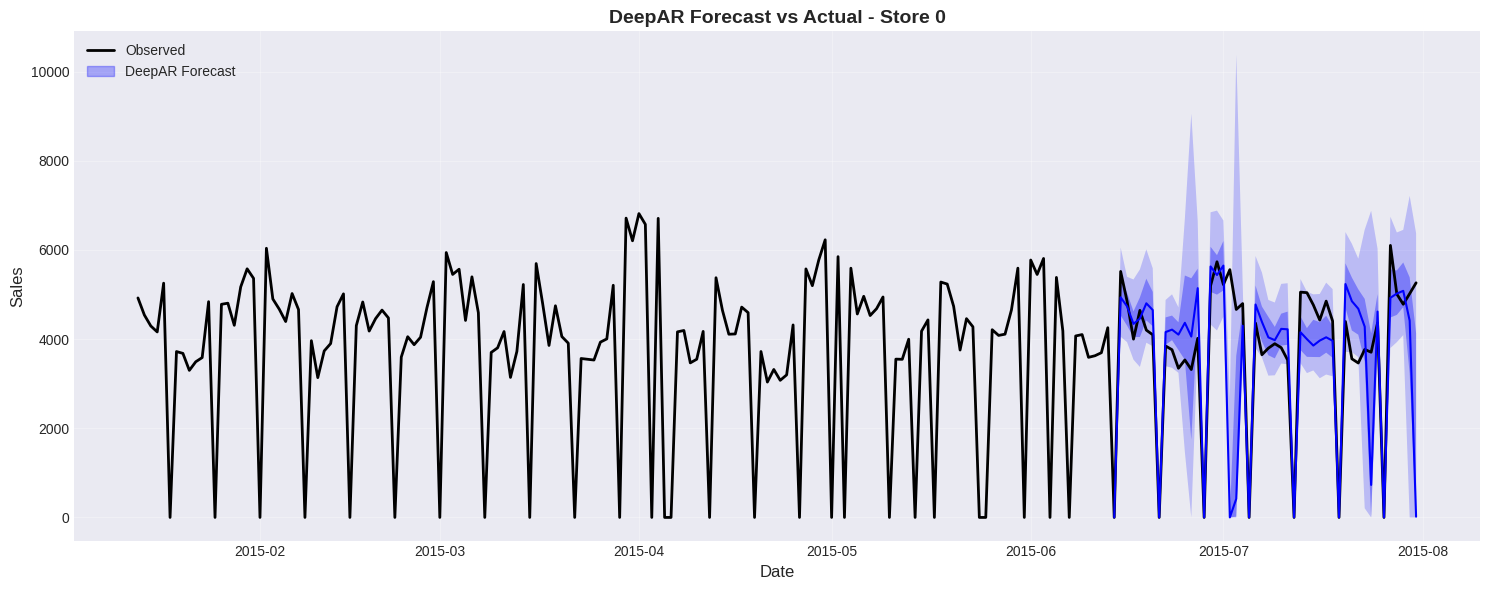

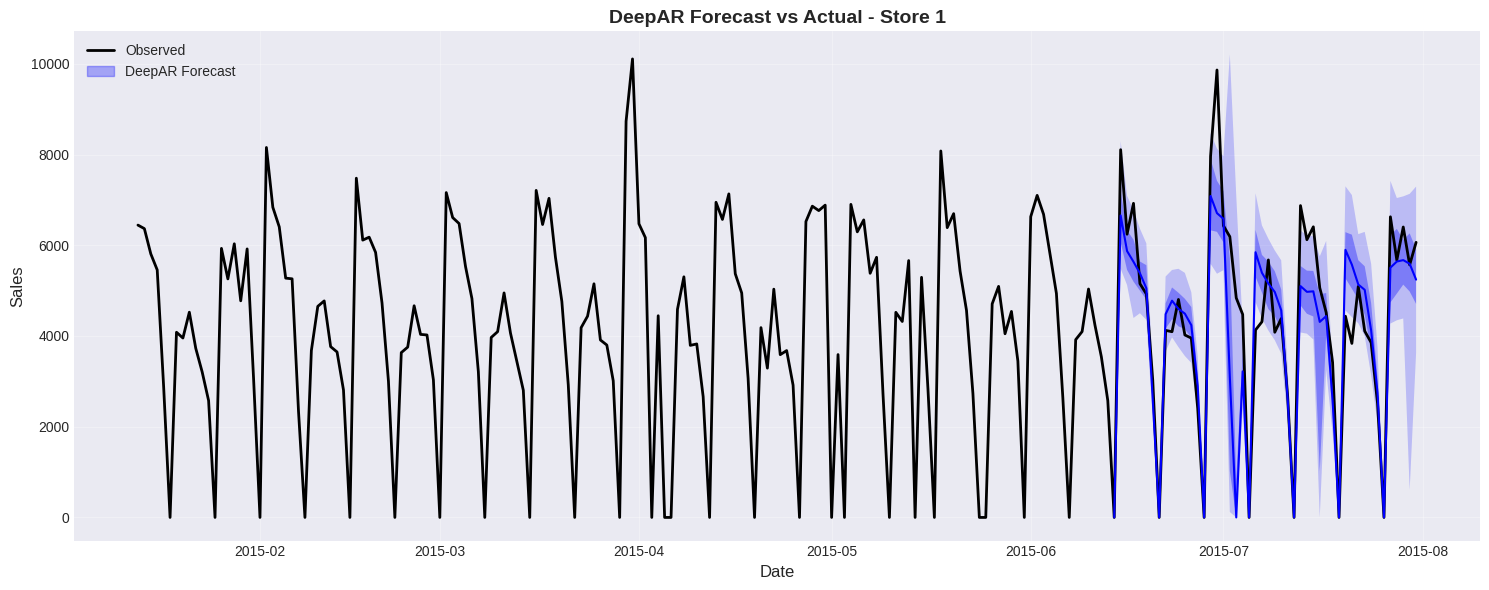

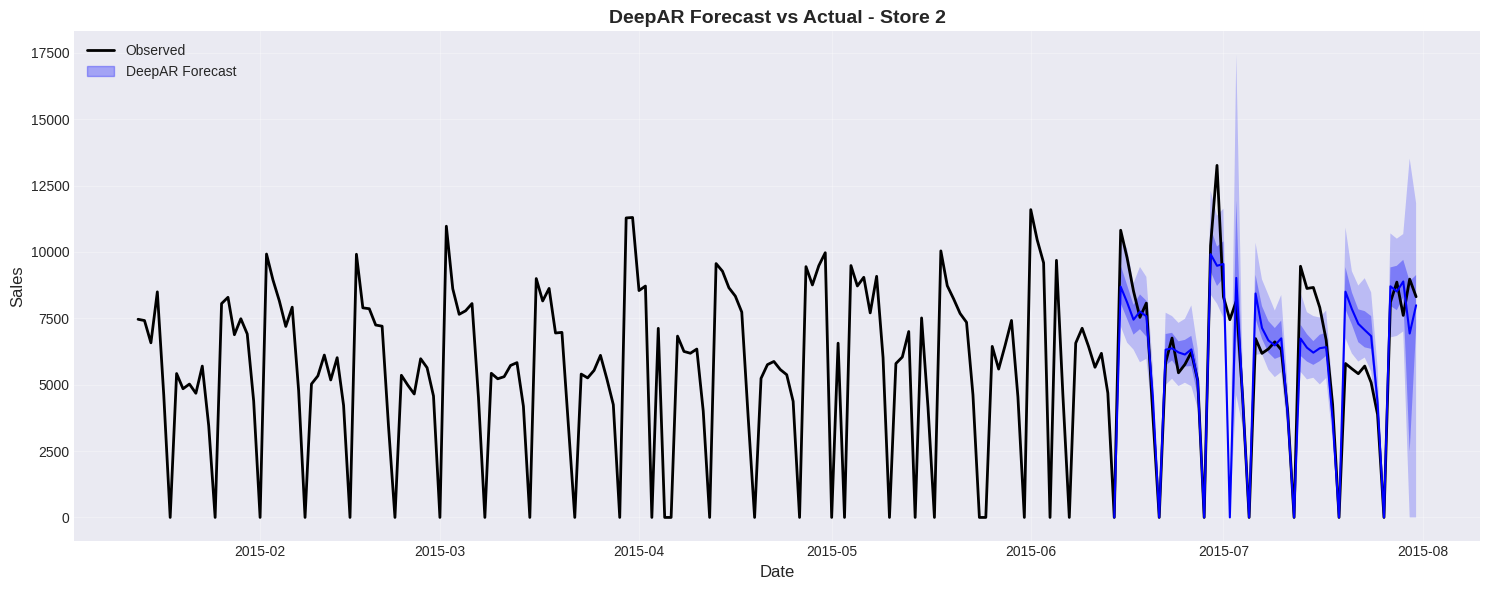

In [23]:
def plot_forecast(ts, forecast, prediction_length: int, sample_id: int,
                 plot_length: int = 200, save_path: Optional[Path] = None):
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # 1. Plot Observed Data (Actuals)
    # Convert PeriodIndex to Timestamp for matplotlib compatibility if needed
    if hasattr(ts.index, 'to_timestamp'):
        ts_index = ts.index.to_timestamp()
    else:
        ts_index = ts.index
        
    ts_values = ts.to_numpy()
    
    # Limit plot to last plot_length points
    start_idx = max(0, len(ts_values) - plot_length)
    
    ax.plot(ts_index[start_idx:], ts_values[start_idx:], 
            label='Observed', color='black', linewidth=2)
    
    # 2. Plot Forecast
    # REMOVED: 'label' and 'interval_alpha' arguments which caused errors
    forecast.plot(ax=ax, color='blue')
    
    # MANUALLY add the forecast label to the legend
    # We grab the last plotted line/collection (which is the forecast mean) to label it
    handles, labels = ax.get_legend_handles_labels()
    # Create a proxy artist for the forecast to ensure it shows up in the legend correctly
    import matplotlib.patches as mpatches
    forecast_patch = mpatches.Patch(color='blue', alpha=0.3, label='DeepAR Forecast')
    handles.append(forecast_patch)
    
    # 3. Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.set_title(f'DeepAR Forecast vs Actual - Store {sample_id}', fontsize=14, fontweight='bold')
    ax.legend(handles=handles, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

print(f"\nPlotting {Config.NUM_PLOTS} sample forecasts...")
for i in range(min(Config.NUM_PLOTS, len(deepar_forecasts))):
    plot_forecast(
        ts=deepar_tss[i],
        forecast=deepar_forecasts[i],
        prediction_length=Config.PREDICTION_LENGTH,
        sample_id=i,
        plot_length=Config.PLOT_LENGTH,
        save_path=Path(Config.PLOTS_DIR) / f'deepar_forecast_{i}.png'
    )

### 8.2 Error Distribution
Analyzing the residuals (Actual - Predicted) to check for bias. A well-performing model should have errors centered around zero.

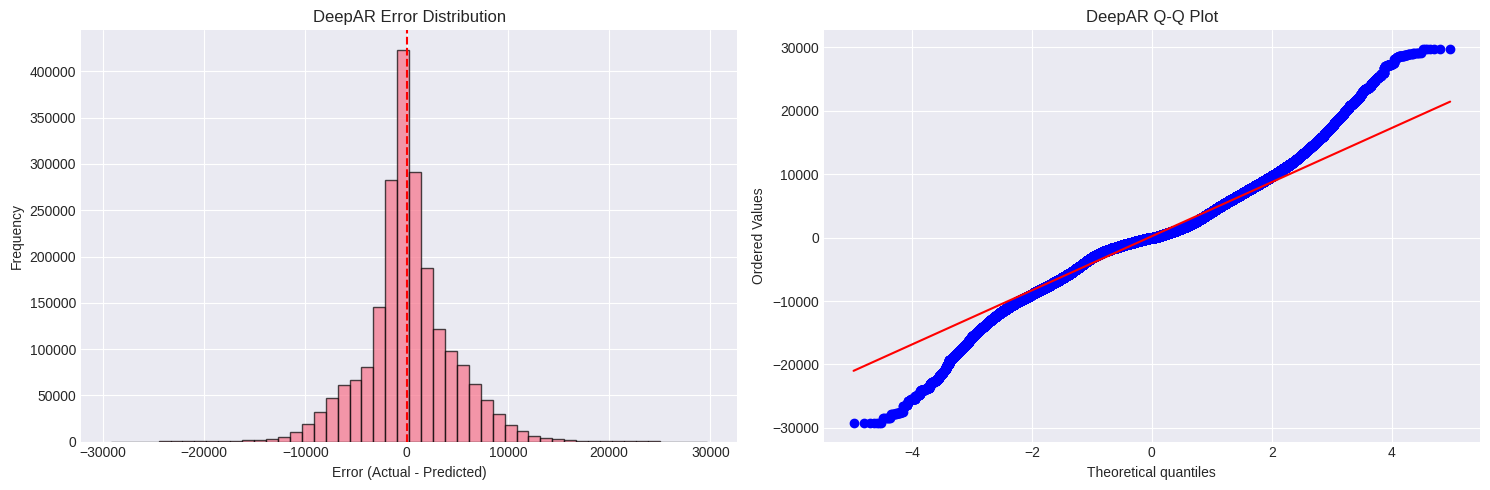

Mean Error (Bias): 211.42
Standard Deviation: 4325.26


In [33]:
def plot_error_distribution(forecasts, tss, model_name="DeepAR"):
    errors = []
    for ts, forecast in zip(tss, forecasts):
        # Align forecast with ground truth
        # Ensure we are comparing the same time periods
        true_values = ts.to_numpy()[-Config.PREDICTION_LENGTH:]
        pred_values = forecast.mean
        
        # Calculate error and append
        # flatten() ensures we add individual floats, not arrays, avoiding nested shapes
        error = true_values - pred_values
        errors.extend(error.flatten())
    
    # Convert to numpy array and ensure 1D
    errors = np.array(errors)
    
    # Remove NaNs if any (DeepAR can sometimes produce NaNs in empty windows)
    errors = errors[~np.isnan(errors)]
    
    # Check if we have data to plot
    if len(errors) == 0:
        print("No valid errors to plot.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--')
    axes[0].set_xlabel('Error (Actual - Predicted)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{model_name} Error Distribution')
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=axes[1])
    axes[1].set_title(f'{model_name} Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mean Error (Bias): {errors.mean():.2f}")
    print(f"Standard Deviation: {errors.std():.2f}")

plot_error_distribution(deepar_forecasts, deepar_tss)